In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from unityagents import UnityEnvironment

from inspect import getsource
import torch
import random
from collections import deque

from ressource.Agent_PER import Agent as Agent_PER
from ressource.Q_network import QNet
from ressource.ReplayBuffer import ReplayBuffer

#### Parameters & utils functions

In [3]:
path_model = r'./model'
path_result = r'./result'

def save_scores(scores_record, AVERAGE_ON_RECORD, suffix):

    df_res = pd.DataFrame()
    df_res['episode'] = np.array([x*AVERAGE_ON_RECORD for x in range(1, len(scores_record)+1)])
    df_res['score'] = np.array(scores_record)
    
    now = datetime.now()
    res_name = f'{str(now.month).zfill(2)}_{str(now.day).zfill(2)}_{now.hour}h{now.minute}_scores_{suffix}'
    df_res.to_csv(os.path.join(path_results, res_name), index=False)
    
def load_agent(modelname, path_model, use_dueling_net=True, use_DDQN=True):

    checkpoint = torch.load(os.path.join(path_model, fr'{modelname}.pth'))

    agent = Agent_PER(state_size, action_size, use_dueling_net, use_DDQN)
    agent.QNet_local.load_state_dict(checkpoint)
    agent.QNet_target.load_state_dict(checkpoint)

    return agent


_____

### Launch the environment

In [4]:
banana_path= r"Banana_Windows_x86_64\Banana.exe"
env = UnityEnvironment(file_name=banana_path)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Description of the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


When finished, you can close the environment.


___
## Training  

In [6]:
agent = Agent_PER(state_size, action_size, use_dueling_net=True, use_DDQN=False)

### One episode

In [7]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]           # get the current state
score = 0                                         # initialize the score

while True:
    
    action = agent.act(state)                     # select an action
    
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    
    agent.step(state, action, reward, next_state, done) 
    
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


### Training agent over many episodes

The training will end when the target of a score of more than 13 over the last 100 episodes is reached or if N_EPISODES elapsed. 

Environnement solved in 1940 episodes with score 13.01 over last 100 episodes!


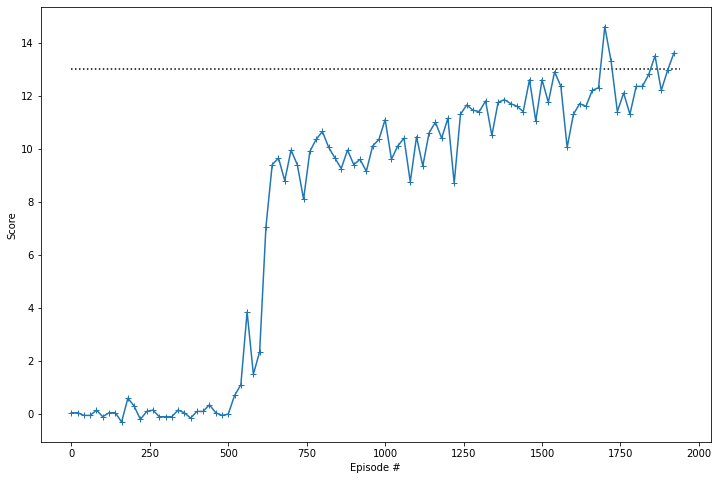

Wall time: 1h 57min 29s


In [8]:
%%time

_model_suffix = ''     # specific model name for saving

AVERAGE_PASS_ENV = 100 # The score to pass has to be average on the last x episodes
SCORE_TO_PASS = 13

AVERAGE_ON_RECORD = 20
N_EPISODES = 2_500

cnt_record = 0
environment_solved = False
scores_record = deque()
scores_window = deque(maxlen=max(AVERAGE_ON_RECORD, AVERAGE_PASS_ENV))

for i in range(1, N_EPISODES + 1):
    
    if environment_solved:
        break
    # reset the environment and get the initial state
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations[0]           
    score = 0                                         
    
    while True:
        
        # select an action
        action = agent.act(state)                     
        
        # send the action to the environment
        env_info = env.step(action)[brain_name]   
        # get the next state
        next_state = env_info.vector_observations[0] 
        # get the reward
        reward = env_info.rewards[0]  
         # see if episode has finished
        done = env_info.local_done[0]                 
        
        # save the experience and decide to learn or to continue interacting
        agent.step(state, action, reward, next_state, done) 
        
        # update the score
        score += reward                                
        state = next_state
        
        # Record score, check if the environment is solved and escape the loop.
        if done:                                       
            
            scores_window.append(score)
            cnt_record += 1
            
            # Record the averaged score when needed
            if cnt_record % AVERAGE_ON_RECORD == 0:
                score_averaged = np.mean(list(scores_window)[-AVERAGE_ON_RECORD:])
                scores_record.append(score_averaged)
                cnt_record = 0
                print(f"\rEpisode {i} Score: {score_averaged}", end='\r')
            
            # Check if the environnment is solved
            if len(scores_window) >= AVERAGE_PASS_ENV :
                score_averaged = np.mean(list(scores_window)[-AVERAGE_PASS_ENV:])
                if score_averaged > SCORE_TO_PASS:
                    environment_solved = True
                    print(f"\rEnvironnement solved in {i} episodes with score {score_averaged} over last {AVERAGE_PASS_ENV} episodes!")
                    now = datetime.now()
                    modelname = f'{str(now.month).zfill(2)}_{str(now.day).zfill(2)}_{now.hour}h{now.minute}_Qnet{_model_suffix}'
                    torch.save(agent.QNet_local.state_dict(), os.path.join(path_model, fr'{modelname}.pth'))
                    
            break
            
# plot the scores
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
ax.hlines(13, 0, len(scores_record)*AVERAGE_ON_RECORD, 'k', linestyle=':')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [16]:
save_scores(scores_record, AVERAGE_ON_RECORD, suffix='solved_in_1940')

_____

### Load a trained agent and watch it interact for one episode

In [12]:
agent = load_agent('per_ddqn_dueling_16k', path_model)

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: 16.0
